In [1]:
import math
import pandas as pd
import numpy as np
import geopandas as gpd
from pyproj import Proj
from shapely.geometry import MultiPolygon
from shapely.geometry import Point

from keplergl import KeplerGl
import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#['N139LB', 'N166LB', 'N191LB', 'N211LB', 'N221LB', 'N225LB', 'N226LB', 'N228LB', 'N234LB',\
#                   'N235LB', 'N238LB', 'N252LB', 'N253LB', 'N271LB', 'N329LB', 'N789LB']

flights_to_add = ['N139LB', 'N166LB', 'N191LB', 'N211LB', 'N221LB', 'N225LB', 'N226LB', 'N228LB', 'N234LB',\
                  'N235LB', 'N238LB', 'N252LB', 'N253LB', 'N271LB', 'N329LB', 'N789LB']

raw_df = pd.DataFrame()

for loon in flights_to_add:
    
    aux = pd.read_csv('../../../../og_data/ST-DBSCAN/ST-' + loon + '-country.csv', parse_dates=['ts'],\
                           low_memory=False)
    
    
    raw_df = raw_df.append(aux)

In [3]:
bl = raw_df
bl['time_since_last_record'] = pd.to_timedelta(bl['time_since_last_record'])


In [4]:
gdf = gpd.GeoDataFrame(bl, geometry=gpd.points_from_xy(bl.lon, bl.lat))
gdf.crs = "EPSG:4326"


In [5]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Loons provide around 40 squared km of coverage. We will create circles of the same surface with their centre in
# each one of the traces

# In circles: A = pi * radius^2
radius = math.sqrt((40 * 1000000)/math.pi)
radius

3568.2482323055424

In [8]:
# We just need the traces in Kenya
kenya_bl = gdf.loc[gdf.country == 'Kenya'].copy()

# Project to equal area projection
kenya_bl = kenya_bl.to_crs(epsg='3035')

kenya_bl['radius_geometry'] = kenya_bl.geometry.buffer(radius)
kenya_bl = kenya_bl.set_geometry('radius_geometry')

# Loons to study
kenya_loons = kenya_bl.registration_id.unique()

# Let's break down the dates
kenya_bl['year'] = kenya_bl['ts'].dt.year
kenya_bl['month'] = kenya_bl['ts'].dt.month
kenya_bl['day'] = kenya_bl['ts'].dt.day
kenya_bl['hour'] = kenya_bl['ts'].dt.hour

# Now we take the stationary traces 
kenya_bl_service = kenya_bl.loc[kenya_bl.stationary == True]



In [9]:
# TOTAL AREA COVERED IN Kenya BY THE LOONS (KM2)

total_kenya_area = kenya_bl.geometry.unary_union.area/1000000

total_kenya_area

216403.95062895285

In [10]:
# We can get the percentage of kenyan land our loons covered
kenya_area =1285216 # Already in squared km

total_kenya_area/kenya_area

0.1683794402100136

In [11]:
# TOTAL AREA COVERED IN kenya BY EACH LOON

area_df = pd.DataFrame()
area_df['registration_id'] = kenya_loons
area_df['total_area'] = 0
    

for loon in kenya_loons:
    
    area_in_km = kenya_bl.loc[kenya_bl.registration_id == loon].geometry.unary_union.area/1000000

    area_df.loc[area_df.registration_id == loon, 'total_area'] = area_in_km
    

In [12]:
# SERVICE AREA COVERED IN kenya BY THE LOONS
# How much surface of Perú has been covered by our loons?

service_kenya_area = kenya_bl_service.geometry.unary_union.area/1000000

service_kenya_area

188597.15723489324

In [40]:
service_kenya_area/kenya_area


0.14674354912706755

In [13]:
# SERVICE AREA COVERED IN kenya BY EACH LOON

area_df['service_area'] = 0

for loon in kenya_loons:

    service_area_in_km = kenya_bl_service.loc[kenya_bl_service.registration_id == loon]\
                                                                .geometry.unary_union.area/1000000
    
    area_df.loc[area_df.registration_id == loon, 'service_area'] = service_area_in_km
    

In [14]:
# TIME OF FLIGHT IN kenya OF TARGET LOONS

# We have to exlude large values since we don't know what happend between records
# Following the filter criteria we exclude values larger than  6 hours

kenya_bl.loc[kenya_bl.time_since_last_record > pd.Timedelta('6hours'), 'time_since_last_record'] = pd.Timedelta('0hours')

total_kenya_time = kenya_bl['time_since_last_record'].sum()

total_kenya_time

Timedelta('127 days 17:03:23')

In [15]:
# TIME OF FLIGHT IN kenya OF EACH TARGET LOON

area_df['total_time'] = pd.NaT

for loon in kenya_loons:
    
    total_time = kenya_bl.loc[kenya_bl.registration_id == loon].time_since_last_record.sum()
    area_df.loc[area_df.registration_id == loon, 'total_time'] = total_time
    

In [16]:
# STATIONARY TIME IN kenya OF TARGET LOONS

# We have to exlude large values since we don't know what happend between records
# Following the filter criteria we exclude values larger than  6 hours

kenya_bl_service.loc[kenya_bl_service.time_since_last_record > pd.Timedelta('6hours'), 'time_since_last_record'] = pd.Timedelta('0hours')

service_kenya_time = kenya_bl_service['time_since_last_record'].sum()

service_kenya_time


/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Timedelta('113 days 15:11:29')

In [21]:
# STATIONARY TIME IN kenya OF EACH TARGET LOON
area_df['service_time'] = pd.NaT

for loon in kenya_loons:
    
    stationary_time = kenya_bl_service.loc[kenya_bl_service.registration_id == loon]['time_since_last_record'].sum()
    area_df.loc[area_df.registration_id == loon, 'service_time'] = stationary_time
    
    

In [22]:
area_df

registration_id    total_area  service_area        total_time  \
0           N139LB  10062.580886  10062.580886   2 days 15:29:19   
1           N166LB   9744.984507   7210.726664   1 days 12:13:07   
2           N211LB   9744.984507      0.000000   1 days 12:13:07   
3           N221LB  12348.851474   4856.131492   2 days 11:22:18   
4           N225LB  57330.431860  56440.598234  20 days 20:26:27   
5           N226LB  58612.589797  52534.851632  20 days 04:57:12   
6           N228LB  45304.352006  42039.628004  12 days 04:24:25   
7           N234LB  64005.054704  58179.459375  23 days 18:45:03   
8           N238LB  54464.159244  53745.087436  18 days 23:53:51   
9           N252LB  49310.082736  42994.831029  17 days 18:12:10   
10          N253LB  21930.738528   6333.139835   5 days 19:06:24   

        service_time  
0    2 days 15:29:19  
1    1 days 04:53:17  
2    0 days 00:00:00  
3    1 days 10:37:33  
4   20 days 03:53:59  
5   17 days 17:48:28  
6   11 days 12:01:37  
7   21 days 23:47:39  
8   18 days 08:08:39  
9   16 days 08:46:49  
10   2 days 05:44:09

In [23]:
# When did the first loon providing service appear?
kenya_bl.loc[kenya_bl.stationary == True].sort_values('ts').head(1)['ts']

122822   2020-03-30 14:38:18+00:00
Name: ts, dtype: datetime64[ns, UTC]

In [24]:
# When did the last loon providing service appear?
kenya_bl.loc[kenya_bl.stationary == True].sort_values('ts').tail(1)['ts']

96326   2020-06-14 12:14:26+00:00
Name: ts, dtype: datetime64[ns, UTC]

In [37]:
plot_df = pd.DataFrame(columns=['registration_id', 'area', 'time', 'set of traces'])


for loon in kenya_loons:
    
    aux = area_df.loc[area_df.registration_id == loon]

    plot_df = plot_df.append({'registration_id': loon, 'area': aux.total_area.values[0], \
                              'time': aux.total_time.values[0], 'set of traces': 'All traces'},\
                             ignore_index=True)
    
    plot_df = plot_df.append({'registration_id': loon, 'area': aux.service_area.values[0], \
                              'time': aux.service_time.values[0], 'set of traces': 'Service traces'},\
                             ignore_index=True)

plot_df

registration_id          area             time   set of traces
0           N139LB  10062.580886  2 days 15:29:19      All traces
1           N139LB  10062.580886  2 days 15:29:19  Service traces
2           N166LB   9744.984507  1 days 12:13:07      All traces
3           N166LB   7210.726664  1 days 04:53:17  Service traces
4           N211LB   9744.984507  1 days 12:13:07      All traces
5           N211LB      0.000000  0 days 00:00:00  Service traces
6           N221LB  12348.851474  2 days 11:22:18      All traces
7           N221LB   4856.131492  1 days 10:37:33  Service traces
8           N225LB  57330.431860 20 days 20:26:27      All traces
9           N225LB  56440.598234 20 days 03:53:59  Service traces
10          N226LB  58612.589797 20 days 04:57:12      All traces
11          N226LB  52534.851632 17 days 17:48:28  Service traces
12          N228LB  45304.352006 12 days 04:24:25      All traces
13          N228LB  42039.628004 11 days 12:01:37  Service traces
14          N234LB  64005.054704 23 days 18:45:03      All traces
15          N234LB  58179.459375 21 days 23:47:39  Service traces
16          N238LB  54464.159244 18 days 23:53:51      All traces
17          N238LB  53745.087436 18 days 08:08:39  Service traces
18          N252LB  49310.082736 17 days 18:12:10      All traces
19          N252LB  42994.831029 16 days 08:46:49  Service traces
20          N253LB  21930.738528  5 days 19:06:24      All traces
21          N253LB   6333.139835  2 days 05:44:09  Service traces

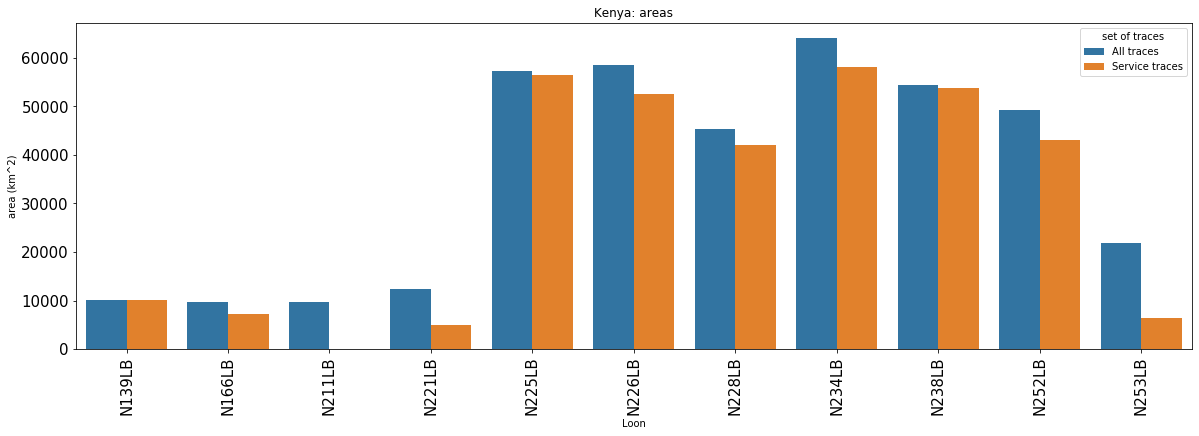

In [38]:

plt.figure(loon, figsize=(20,6))

ax = sns.barplot(x=plot_df['registration_id'], y="area", hue='set of traces',\
                data=plot_df)

#ax.set(ylim=(0, 50))
dummy = ax.set_ylabel('area (km^2)')
dummy = ax.set_xlabel('Loon')
dummy = ax.set_title('Kenya' + ': areas')
dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
dummy = ax.tick_params(labelsize=15)

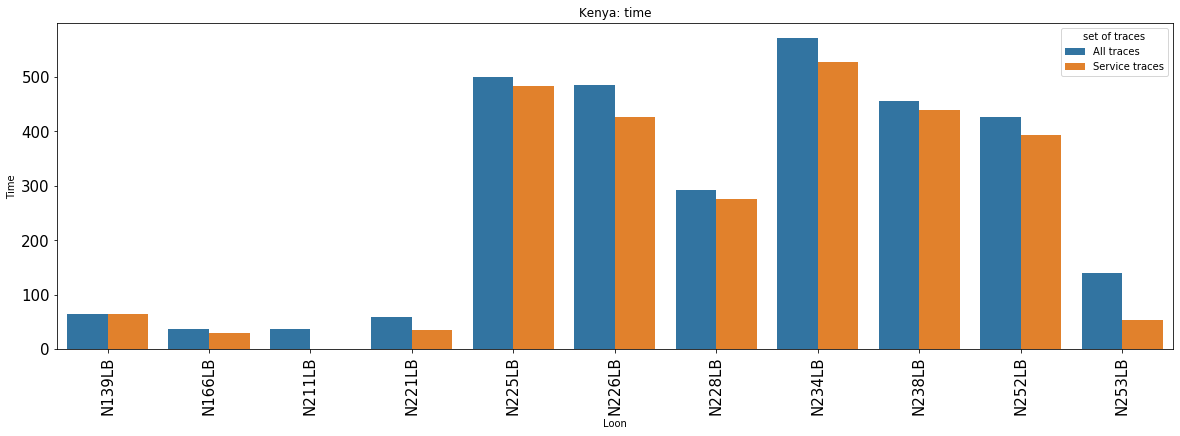

In [39]:
plt.figure(loon, figsize=(20,6))

ax = sns.barplot(x=plot_df['registration_id'], y=plot_df.time.dt.total_seconds()/3600, hue='set of traces',\
                data=plot_df)

#ax.set(ylim=(0, 50))
dummy = ax.set_ylabel('Time')
dummy = ax.set_xlabel('Loon')
dummy = ax.set_title('Kenya' + ': time')
dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
dummy = ax.tick_params(labelsize=15)

In [28]:
# When was Perú better covered?

# Let's get the number of traces of each serviced day

kenya_log = kenya_bl_service.groupby(['year', 'month', 'day'])['ts'].count().reset_index()

kenya_log['num_traces'] = kenya_log['ts']
kenya_log = kenya_log.drop('ts', axis=1)

In [29]:
# Let's get the number of loons of each serviced day
kenya_log['num_loons'] = kenya_bl_service.groupby(['year', 'month', 'day'])['registration_id'].nunique()\
                                                            .reset_index()['registration_id']

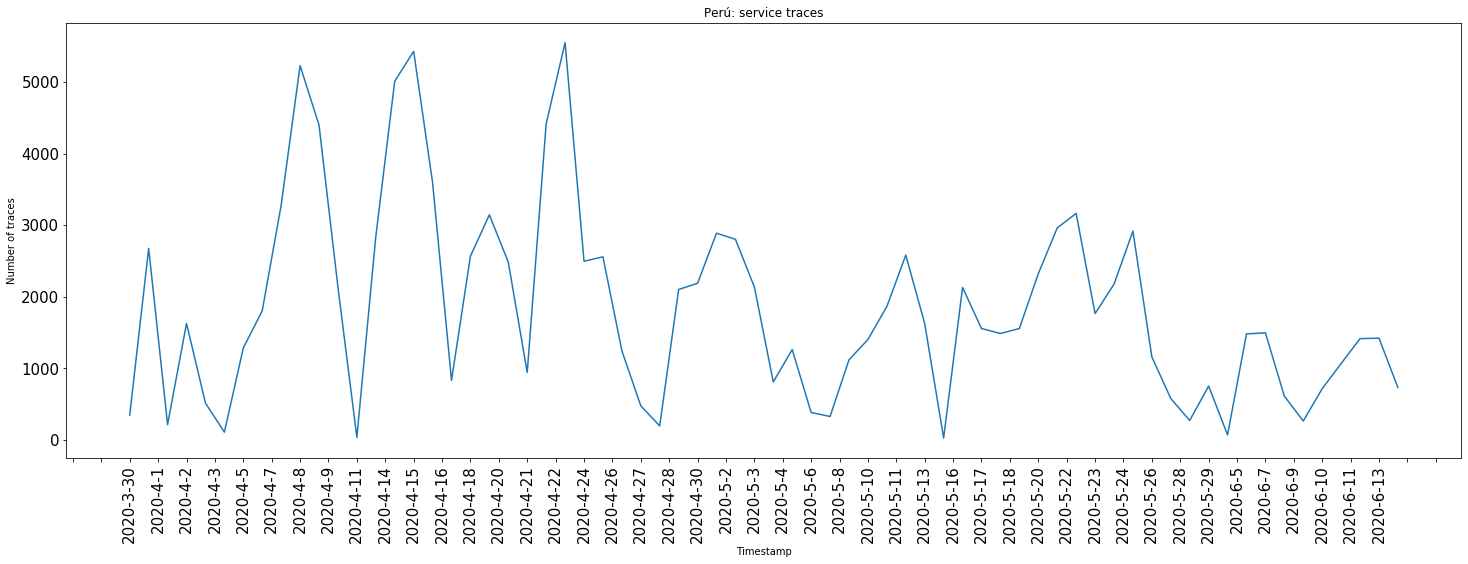

In [30]:
kenya_log['ts'] = kenya_log['year'].astype(str) + '-' + kenya_log['month'].astype(str)\
                            + '-' + kenya_log['day'].astype(str)

plt.figure(loon, figsize=(25,8))

ax = sns.lineplot(x="ts", y="num_traces", data=kenya_log, sort=False)

ax.xaxis.set_major_locator(plt.MaxNLocator(70))

dummy = ax.set_ylabel('Number of traces')
dummy = ax.set_xlabel('Timestamp')
dummy = ax.set_title('Kenya' + ': service traces')
plt.setp(ax.get_xticklabels(), rotation=90)
dummy = ax.tick_params(labelsize=15)

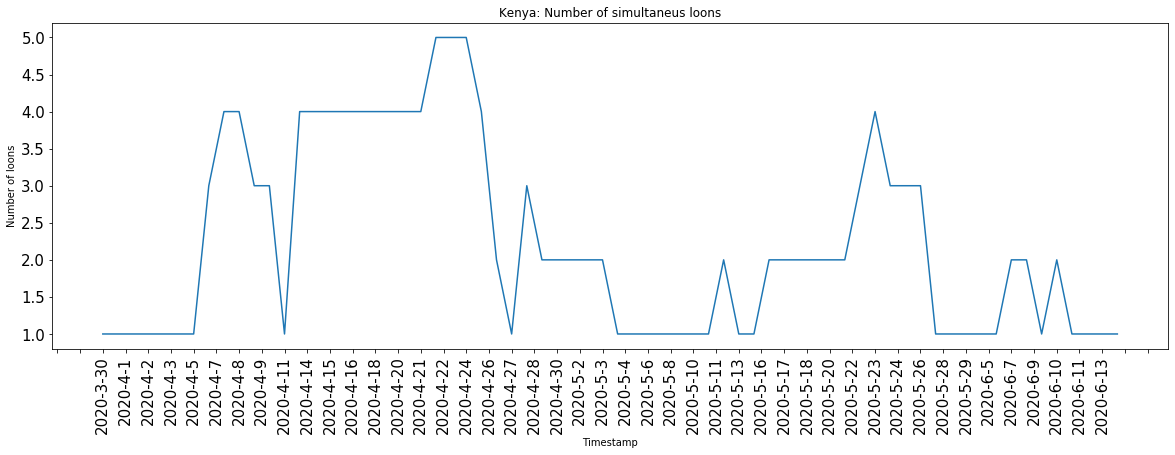

In [31]:

plt.figure(loon, figsize=(20,6))

ax = sns.lineplot(x="ts", y="num_loons", data=kenya_log, sort=False)
ax.xaxis.set_major_locator(plt.MaxNLocator(70))


dummy = ax.set_ylabel('Number of loons')
dummy = ax.set_xlabel('Timestamp')
dummy = ax.set_title('Kenya' + ': Number of simultaneus loons')
plt.setp(ax.get_xticklabels(), rotation=90)
dummy = ax.tick_params(labelsize=15)

In [36]:
# Let's visualize the data on a Heatmap
# ONLY PERÚ SERVICE TRACES

m_1 = folium.Map(location=[-12.046374, -77.042793], zoom_start=5) 

HeatMap(data=kenya_bl_service[['lat', 'lon']], radius=9)\
        .add_to(m_1)

m_1